<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint7/Module2/DS_232_guided_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---


# Wrangle ML datasets
- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [2]:
from glob import glob # seasrching and grouping file names
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests # get info stored on internet, send HTTP requests using python
import tarfile # read and write tar (tape archive files), group several files into one like a zip file. either .tar or .tar.gz if they had a G zip tool
from IPython.display import Image # display couple of visuals

# I. Wrangle Data

1. Download the data [HERE](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis) by clicking the **Download** button on the top right corner of the page.
2. Upload the file to your Google Drive in a folder named "Instacart"

In [ ]:
# # in instructor's video
# # Download data
# def download(url):   # if working on colab, saved temporarily in the present working notebook, or locally current directory
#   filename = url.split('/')[-1]
#   print(f'Downloading {url}')
#   r = requests.get(url)
#   with open(filename, 'wb') as f:    # in write binary mode written in the form of bytes and files contain only text, keep it wb, if 'w' or 'wt' then Python will encode the text, can lead to file being corrupted
#       f.write(r.content)
#   print(f'Downloaded {filename}')

# download('https://lambdaschool-ds-instructions.s3.amazonaws.com/datasets%3Ainstacart_2017_05_01.tar.gz')

# # Uncompress Data
# tarfile.open('datasets%3Ainstacart_2017_05_01.tar.gz').extractall()

# # Change directory to where the data was uncompressed
# !cd instacart_2017_05_01

# # Print the csv filenames
# pattern = 'instacart_2017_05_01/*.csv'   # * is the wild card, make path retrieval simpler, for one or more characters. ? is a wild card just for one character


# for filename in glob(pattern):
#     print(filename)

In [ ]:
# mounting your google drive
from google.colab import drive
drive.mount('/content/gdrive/Instacart/')

In [ ]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Instacart

In [ ]:
!ls

In [ ]:
# Unzip the files, if you haven't already done so.
!unzip \*.zip  && rm *.zip

**Before you start,** load each of the above `.csv` files into its own DataFrame.

In [84]:
# 3 million instacart orders in instructor's data but mine has fewer for some reason?
orders = pd.read_csv('orders.csv')
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')

In [ ]:
Image(url= "https://i.imgur.com/R7c37Yw.png")

## I.a. Warm-up Questions

What information is contained in the column `orders['eval_set']`?

In [38]:
orders['eval_set'].describe()

count     3421083
unique          3
top         prior
freq      3214874
Name: eval_set, dtype: object

In [7]:
orders['eval_set'].value_counts()

prior    1198366
train      48726
test       27951
Name: eval_set, dtype: int64

The first row of `orders['order_id']` is `2539329`. Where can we find the items that were included in that order?

In [8]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1.0,2.0,8.0,NaN
1,2398795,1,prior,2.0,3.0,7.0,15.0
2,473747,1,prior,3.0,3.0,12.0,21.0
3,2254736,1,prior,4.0,4.0,7.0,29.0
4,431534,1,prior,5.0,4.0,15.0,28.0


Order 2539329 belongs to the prior eval_set. To look at the items in this order, we'll have to look for a dataset with product_id column.

In [9]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0


Now we know we have to look at the order_products_prior dataset, we need to locate order_id 2539329 and look at the corresponding product_id.
- we can use a MASK

In [14]:
mask1 = (order_products_prior['order_id'] == 2539329)
order_products_prior[mask1]

,order_id,product_id,add_to_cart_order,reordered


*The* first row of `order_products_prior['product_id']` is `33120`. What is the name of that product?

- we need to check the product_name, so we need to have access to the products.csv file

In [16]:
mask2 = (products['product_id'] == 33120)
products[mask2]

,product_id,product_name,aisle_id,department_id
33119,33120,Organic Egg Whites,86,16


- the name of that product is "Organic Egg Whites".

# Define Our Machine Learning Problem

- We want predict whether or not a customer will purchase a specific item (of our choosing).
- The most commonly ordered product: `'Banana'` (`24852`).
- Our model is going to predict whether or not an order will include a `'Banana'`.

Lets adjust the Kaggle competition classification task from "What products will be ordered?" (multiclass, multilabel classification) to "Will one product be reordered?" (binary classification).

In [20]:
# which product is being ordered most times?
order_products_prior['product_id'].value_counts().head()

24852.0    33235
13176.0    26535
21137.0    18396
21903.0    16880
47209.0    14827
Name: product_id, dtype: int64

In [19]:
# apply a mask without the mask variable
products[products['product_id'] == 24852]

,product_id,product_name,aisle_id,department_id
24851,24852,Banana,24,4


- We're going to add a column to see if a certain order contains banana to turn into a binary classification problem

## I.c. Create Feature Matrix and Target Vector

Our **feature matrix** will be all the `'train'` rows from `orders`.

In [85]:
# filter out all rows with the training set
train_mask = orders['eval_set'] == 'train'
X = orders[train_mask].copy() # create a copy so we're working with a fresh dataframe, and save it to our feature matrix X

# delete eval_set from our data because it's a constant column now containing only the word 'train'
X.drop(columns='eval_set', inplace=True)

In [86]:
X.shape

(131209, 6)

In [24]:
X.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,11.0,4.0,8.0,14.0
25,1492625,2,15.0,1.0,11.0,30.0
49,2196797,5,5.0,0.0,11.0,6.0
74,525192,7,21.0,2.0,11.0,6.0
78,880375,8,4.0,1.0,14.0,10.0


Our **target vector** will be whether or not each order in `X` contains the item we've chosen above. i.e. whether each order contains Banana.

In [87]:
# create a column 'is_banana' to indicate whether the order contains banana or not
order_products_train['is_banana'] = order_products_train['product_id'] == 24852

In [88]:
# get all the order IDs that have banana in them
# create a mask that is True for ['is_banana'], apply the mask to order_products_train, grab the ['order_id'], then save it as banana_orders
banana_orders = order_products_train[order_products_train['is_banana']]['order_id']

In [42]:
banana_orders

115            226
156            473
196            878
272           1042
297           1139
            ...   
1383894    3419531
1383930    3419542
1383960    3419629
1384157    3420088
1384546    3420996
Name: order_id, Length: 18726, dtype: int64

In [89]:
# now go back to X dataframe, and add a column for the binary target vector as 'includes_bananas'
# that column will be formed by matching the order_id in X that are also present in banana_orders, if it's true, it'll be cast as 1
X['includes_bananas'] = X['order_id'].isin(banana_orders).astype(int)

In [44]:
X['includes_bananas']

10         0
25         1
49         0
74         0
78         0
          ..
3420838    0
3420862    0
3420924    0
3420933    1
3421082    1
Name: includes_bananas, Length: 131209, dtype: int64

# I.d Feature Engineering
- Go to Split Data first

## What features can we engineer? We want to predict, will these customers reorder bananas on their next order?

- Products per order
- Time of day
- Have they reordered bananas before? (Have ordered bananas >= 2 times)
- Other fruit they buy
- Size of orders (customers with smaller orders on average are less likely to be reordering any particular product on their next order)


- Frequency of banana orders:
    - % of orders
    - Time between banana orders: Every n days on average
    - Raw count: Total orders, how many times have you ordered bananas?

- Recency of banana orders
    - n days since you ordered banana

**There are many questions we can ask, but today we're only addressing 3.**

In [68]:
# we need to rerun the cell to load the csv files again, the train mask, and the is banana, banana orders cells

1) Is an order placed before 11:00AM?

In [90]:
# check if X['order_hour_of_day'] <= 11, if it is then cast the boolean into integer
X['morning_order'] = (X['order_hour_of_day'] <= 11).astype(int)

In [91]:
X.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,includes_bananas,morning_order
10,1187899,1,11,4,8,14.0,0,1
25,1492625,2,15,1,11,30.0,1,1
49,2196797,5,5,0,11,6.0,0,1
74,525192,7,21,2,11,6.0,0,1
78,880375,8,4,1,14,10.0,0,0


*This might or might not be helpful. Unfortunately, close to 80% of the time, any feature engineering that we do does not help the model as much as we want to, but we have to do our best to extract info from the dataset.*

2) How many items in the order?

In [92]:
# we apply the python function groupby and access the count of product_id, then rename the dataframe as n_items
# if we don't rename it, the name of the series will still be product_id and it can be misleading
order_products_train.groupby('order_id')['product_id'].count().rename('n_items')

order_id
1           8
36          8
38          9
96          7
98         49
           ..
3421049     6
3421056     5
3421058     8
3421063     4
3421070     3
Name: n_items, Length: 131209, dtype: int64

In [93]:
n_items_per_order = order_products_train.groupby('order_id')['product_id'].count().rename('n_items')

In [94]:
# now we merge the two dataframes together, and then re-assign X
X = X.merge(n_items_per_order,
        how='left', # we want to keep the left dataframe intact (the X dataframe), we're keeping all the rows in X dataframe intactX
        left_on='order_id', # this is what the common value is
        right_index=True # the order_id in the right dataframe is in its index i.e. using the index in our right dataframe as the join key
        )

In [95]:
X.shape

(131209, 9)

In [96]:
X.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,includes_bananas,morning_order,n_items
10,1187899,1,11,4,8,14.0,0,1,11
25,1492625,2,15,1,11,30.0,1,1,31
49,2196797,5,5,0,11,6.0,0,1,9
74,525192,7,21,2,11,6.0,0,1,9
78,880375,8,4,1,14,10.0,0,0,18


3) Did the user order `'Banana'` in previous orders?

In [97]:
# first we're checking if the order_products_prior contains banana or not, then grab their order_id
order_products_prior['is_banana'] = order_products_prior['product_id'] == 24852
banana_orders_id_prior = order_products_prior[order_products_prior['is_banana']]['order_id']

# grab prior orders rows in orders dataset
prior_orders = orders[orders['eval_set']=='prior'].copy()
# match the order_id in orders dataset to order_id in order_products_prior dataset
prior_orders['has_banana'] = prior_orders['order_id'].isin(banana_orders_id_prior)

# we're doing this because only the orders dataset contains user_id

# grab the unique user id in the orders dataset after selecting the correct order_id
prior_banana_user_ids = prior_orders[prior_orders['has_banana']]['user_id'].unique()

# create a new column of 0 or 1 whether the user has ordered bananas before or not
X['prior_banana_orders'] = X['user_id'].isin(prior_banana_user_ids).astype(int)

In [98]:
X.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,includes_bananas,morning_order,n_items,prior_banana_orders
10,1187899,1,11,4,8,14.0,0,1,11,0
25,1492625,2,15,1,11,30.0,1,1,31,1
49,2196797,5,5,0,11,6.0,0,1,9,0
74,525192,7,21,2,11,6.0,0,1,9,0
78,880375,8,4,1,14,10.0,0,0,18,0


In [99]:
X.shape

(131209, 10)

# II. Split Data

In [100]:
target = 'includes_bananas'

y = X[target]

# dropping high cardinality and identifying columns in addition to the target column
X = X.drop(columns=['order_id', 'user_id', 'order_number', target])

In [101]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# III. Establish Baseline

In [102]:
# baseline is the majority class for a classification problem
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.8569931502281669


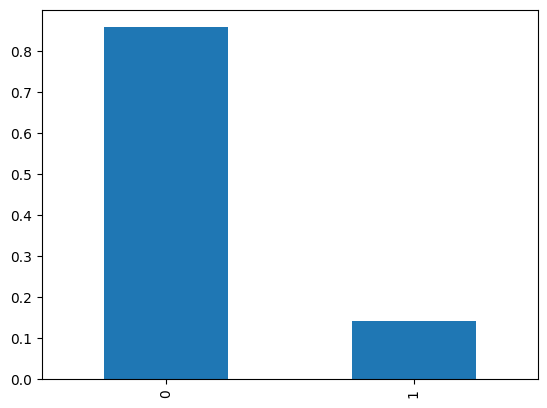

In [103]:
y_train.value_counts(normalize=True).plot(kind='bar');

We're looking at an imbalanced data set today.
- we can either balance our dataset before building our model as a stretch goal by generating synthetic samples or resampling our data
- but for now we're just going to proceed

# IV. Build Model

In [104]:
# none of the columns are categorical so we don't need encoding, don't have to make pipeline
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

# V. Check Metrics

In [58]:
# First run with simple model without engineering any features
print('RF Training Accuracy:', model_rf.score(X_train, y_train))
print('RF Validation Accuracy:', model_rf.score(X_val, y_val))

RF Training Accuracy: 0.8579744110053635
RF Validation Accuracy: 0.8570611996036888


- Before engineering 3 new features, our model isn't doing better than our baseline. Other than because our data is imbalanced, the feature matrix that we created is also not a good predictor of whether someone is going to order bananas or not.
- we should create features which can be useful for our model to predict whether an order will contain a banana or not
  - maybe we look at whether the customer ordered bananas previously?
  - maybe we look at the size of the order? Will a bigger order an indicator or whether bananas will be included?
  - maybe time of day the order is placed? it's a banana, so people tend to have it for breakfast? Maybe morning orders will more likely contain bananas?
  - maybe check if other fruits are included in their orders too?
  - maybe how many days since an order of bananas was placed?

NOW GO BACK TO FEATURE ENGINEERING.

In [105]:
# AFTER ENGINEERING 3 NEW FEATURES
print('RF Training Accuracy:', model_rf.score(X_train, y_train))
print('RF Validation Accuracy:', model_rf.score(X_val, y_val))


RF Training Accuracy: 0.9464403098116551
RF Validation Accuracy: 0.8386555902751315


As we can see our training accuracy went up but our validation accuracy went down. We might need to do some hyperparameter tuning, or even a grid search, trying to improve our model.